In [1]:
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tt
from PIL import Image
import matplotlib.pyplot as plt

from custom_diffusion.diffusion import Diffusion
from custom_diffusion.model import Unet

In [ ]:
torch.backends.cuda.enable_flash_sdp(True)
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_math_sdp(False)

In [2]:
checkpoint_path = 'checkpoint.pth'
dataset_path = 'faces_dataset_small'
img_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype= torch.float32

In [3]:
class FaceDataset(Dataset):
    def load_img(self, file):
        image = Image.open(file)
        image.load()
        return image
    
    def __init__(self, path, dataset_size=3143, img_size=64):
        super().__init__()
        assert dataset_size <= 3143, 'dataset_size is too big'
        path = Path(path)
        self.files = sorted(list(path.rglob('*.png')))[:dataset_size]
        self.size = (img_size, img_size)
        self.len_ = len(self.files)
        transforms = tt.Compose([
            tt.Resize(size=self.size),
            tt.RandomHorizontalFlip(),
            tt.ToTensor(),
            tt.Lambda(lambda t: (t * 2) - 1)
        ])
        imgs = [transforms(self.load_img(file)) for file in self.files]
        self.imgs = torch.stack(imgs).to(device, dtype=dtype)
        
    def __len__(self):
        return self.len_
    
    def __getitem__(self, index):
        return self.imgs[index]

In [4]:
faces = FaceDataset(path=dataset_path, img_size=img_size)
loader = DataLoader(faces, batch_size=64)

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:
unet = Unet(img_size=img_size, model_size=6, timestamps_num=1000, in_channels=3, out_channels=3)
count_parameters(unet)

159893283

In [7]:
diffusion = Diffusion(Unet, T=1000, device=device, dtype=dtype)
diffusion.load_state_dict(checkpoint_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

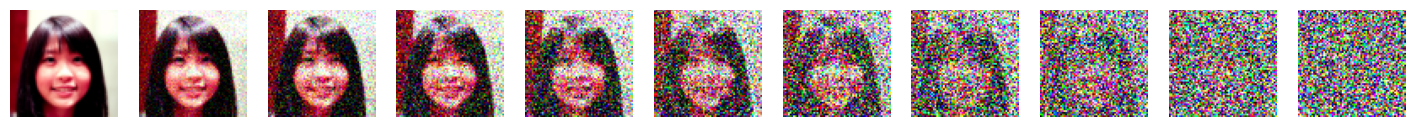

In [8]:
x = next(iter(loader))[0]
diffusion.forward_show(x)

In [ ]:
losses = diffusion.train(loader,epochs=500, checkpoint_path='/kaggle/working/checkpoint.pth')

In [ ]:
plt.plot(losses)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

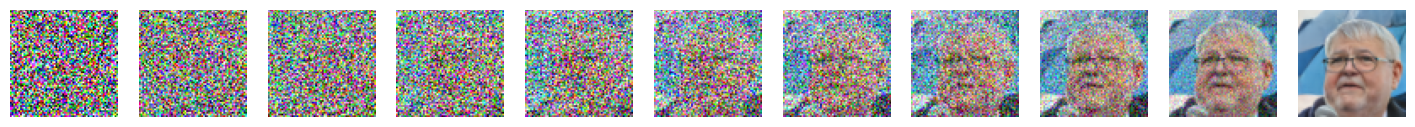

In [14]:
diffusion.backward_show()
plt.show()